In [1]:
# coding: utf-8

# In[1]:

from __future__ import division
import joblib
import glob
import os
import numpy as np
import nrrd
import numpy as np
from sklearn import datasets, svm, metrics, decomposition
from sklearn.externals import joblib
import time
from joblib import Parallel, delayed  
import multiprocessing
num_cores = multiprocessing.cpu_count()
USERPATH = os.path.expanduser("~")
print(USERPATH)
import six.moves.cPickle as pickle

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils, generic_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# tb = TensorBoard(log_dir='/tmp/tensorboard', histogram_freq=1, write_graph=True)

# In[2]:

# tipsPath = "/Projects/Tips/"
# notipsPath = "/Projects/RandomCubes/"
notipsPath = "/Dropbox/2016-projectweekdata/RandomCubes/"
tipsPath = "/Dropbox/2016-projectweekdata/Tips/"

# fix random seed for reproducibility
seed = 7
checkpointer = ModelCheckpoint(filepath="weights2d.hdf5", verbose=1, save_best_only=True)


def loadAllDataFromPath(path):
    # path in directorty
    cubeTipsPath = glob.glob(USERPATH + path + "*.nrrd")
    # number of samples
    N = len(cubeTipsPath)
    print('number of sample %d' %N)
    cubeTips = []
    for path_i in cubeTipsPath:
        cubeTips.append(nrrd.read(path_i))
    data = [[] for i in range(N)]
    for i in range(N):
        # c = np.array(cubeTips[i][0])  # for patches of size 20,20,20
        c = np.array(cubeTips[i][0][5:-5,5:-5,5:-5]) # for patches of size 10,10,10
        data[i] = c

    output = np.array(data)
    return output



####
## The data is saved to numpy array to speed-up the loading. Uncomment lines below to create a new dataset
####
# In[4]:
# #
tips = loadAllDataFromPath(tipsPath)
notips = loadAllDataFromPath(notipsPath)[:5*len(tips)]
print(len(tips), len(notips))

target_0 = [0 for i in range(len(notips))]
target_1 = [1 for i in range(len(tips))]
y_train = np.array(target_0 + target_1)
print('target shape:', y_train.shape)
X_train = np.array(list(notips)+list(tips))

print('data shape:', X_train.shape)


# now, we have **data**: 2D array of randomCubes then tips and **target** 2D array of 0, then 1

# In[5]:

f_Xtrain = open('X_data_n%d.save'%o, 'wb')
f_ytrain = open('y_data_n%d.save'%o, 'wb')

pickle.dump(X_train, f_Xtrain, protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(y_train, f_ytrain, protocol=pickle.HIGHEST_PROTOCOL)

f_Xtrain.close()
f_ytrain.close()


# In[6]:

# Load the dataset
f_Xdata = open('X_data_n%d.save'%o, 'rb')
f_ydata = open('y_data_n%d.save'*o, 'rb')

X_data = pickle.load(f_Xdata)
X_data = X_data.astype('float32')

# normalize the raw data
X_data -= np.mean(X_data)
X_data /= np.std(X_data)

## second method for normalization
# X_data /= 255

y_data= pickle.load(f_ydata)
y_data_binary = to_categorical(y_data)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_data)
y_data = encoder.transform(y_data)

print("Data shape and label shape")
print(X_data.shape, y_data.shape)

# In[7]:

def shuffle_in_unison_inplace(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


# init the global var
model = 0
x = 14

def create_baseline():

    nb_classes = 1

    # create model
    global model
    if x ==7:
        model = Sequential()

        model.add(Convolution2D(10, 10, 2, border_mode='same',
                                input_shape=(10,10,10)))
        model.add(Activation('relu'))
        model.add(Convolution2D(10, 3, 3))
        model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))

        model.add(Convolution2D(40, 5, 3, border_mode='same' ))
        model.add(Activation('relu'))
        model.add(Convolution2D(40, 5, 3, border_mode='same'))
        model.add(Activation('relu'))
        model.add(Convolution2D(40, 5, 3))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))

        model.add(Flatten())
        model.add(Dense(480))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(480))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(nb_classes))
        model.add(Activation('sigmoid'))

    if x == 11:
        model = Sequential()
        model.add(Convolution2D(10, 10, 10, border_mode='same',
                                batch_input_shape=(10, 10, 10)))
        # model.add(ZeroPadding2D((1, 1), batch_input_shape=(1, 3, 10, 10)))
        model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        model.add(Flatten(input_shape=(512,3,3)))
        model.add(Dense(480))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(480))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(nb_classes))
        model.add(Activation('sigmoid'))

    if x ==13:
        model = Sequential()
        model.add(ZeroPadding2D((1, 1), input_shape=(10,10,10)))
        model.add(Convolution2D(10, 10, 2, border_mode='same',
                                ))
        model.add(Activation('relu'))
        model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        model.add(Dropout(0.5))

        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
        model.add(MaxPooling2D((2, 2), strides=(1, 1)))

        model.add(Dropout(0.5))

        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
        model.add(MaxPooling2D((2, 2), strides=(1, 1)))

        model.add(Dropout(0.5))
        #
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
        model.add(MaxPooling2D((2, 2), strides=(1, 1)))

        model.add(Dropout(0.5))
        #
        # model.add(ZeroPadding2D((1, 1)))
        # model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
        # model.add(ZeroPadding2D((1, 1)))
        # model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
        # model.add(ZeroPadding2D((1, 1)))
        # model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
        # model.add(MaxPooling2D((2, 2), strides=(1, 1)))

        # model.add(Convolution2D(40, 3, 3, border_mode='same' ))
        # model.add(Activation('relu'))
        # model.add(Convolution2D(40, 3, 3, border_mode='same'))
        # model.add(Activation('relu'))
        # model.add(Convolution2D(40, 3, 3))
        # model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2, 2)))
        # model.add(Dropout(0.1))

        model.add(Flatten())
        model.add(Dense(512*3*3))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(480))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(nb_classes))
        model.add(Activation('sigmoid'))
        
    if x ==14:
        model = Sequential()

        model.add(Convolution2D(20,9,9, border_mode='same',
                                input_shape=(10,10,10)))
#         model.add(Activation('relu'))
        model.add(Convolution2D(20,9,9))
        model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))

#         model.add(Convolution2D(40, 5, 3, border_mode='same' ))
#         model.add(Activation('relu'))
#         model.add(Convolution2D(40, 5, 3, border_mode='same'))
#         model.add(Activation('relu'))
#         model.add(Convolution2D(40, 5, 3))
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.1))

        model.add(Flatten())
#         model.add(Dense(480))
#         model.add(Activation('relu'))
#         model.add(Dropout(0.5))
        model.add(Dense(480))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(nb_classes))
        model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

# np.random.seed(seed)
estimators = []
# estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, nb_epoch=200,
                                          batch_size=64, verbose=1)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(y=y_data, n_folds=4, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X_data, y_data, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

json_string = model.to_json()
model.save_weights('my_model_weights_2d_%d.h5'%x, overwrite=True)
open('my_model_architecture%d.json'%x, 'w').write(json_string)

/Users/GP1514


Using TensorFlow backend.


Data shape and label shape
(1509, 10, 10, 10) (1509,)
Epoch 1/200
1131/1131 [==============================] - 0s - loss: 0.6412 - acc: 0.6198     
Epoch 2/200
1131/1131 [==============================] - 0s - loss: 0.4340 - acc: 0.8276     
Epoch 3/200
1131/1131 [==============================] - 0s - loss: 0.3394 - acc: 0.8621     
Epoch 4/200
1131/1131 [==============================] - 0s - loss: 0.2805 - acc: 0.8877     
Epoch 5/200
1131/1131 [==============================] - 0s - loss: 0.2325 - acc: 0.9178     
Epoch 6/200
1131/1131 [==============================] - 0s - loss: 0.1939 - acc: 0.9284     
Epoch 7/200
1131/1131 [==============================] - 0s - loss: 0.1870 - acc: 0.9266     
Epoch 8/200
1131/1131 [==============================] - 0s - loss: 0.2016 - acc: 0.9266     
Epoch 9/200
1131/1131 [==============================] - 0s - loss: 0.1799 - acc: 0.9363     
Epoch 10/200
1131/1131 [==============================] - 0s - loss: 0.1658 - acc: 0.9319     
Epoch

2275

In [2]:
# we load a test case
nrrdData = nrrd.read('/Users/GP1514/Dropbox/2016-projectweekdata/Output Volume.nrrd')
im = nrrdData[0]
im = im[100:160,80:130,70:130]
s = im.shape
print(s)
p=10

(60, 50, 60)


In [8]:
import pyprind
import sys
def findtips(N, p=20):
    '''
    Find the tip in the image by computing testing patches at every voxel position
    TODO: make this method more efficient
    '''
    p = p
    xmiddle = s[0]//2
    ymiddle = s[1]//2
    zmiddle = s[2]//2
    
    x0= xmiddle - xmiddle//N
    y0= ymiddle - ymiddle//N
    z0= zmiddle - zmiddle//N
    
    xe= xmiddle + xmiddle//N
    ye= ymiddle + ymiddle//N
    ze= zmiddle + zmiddle//N
    
    tips = []
    bar = pyprind.ProgBar(xmiddle//N*2, title='Find_tip', stream=sys.stdout)
    for xi in range(x0, xe-p):
        for yi in range(y0, ye-p):
            vols = [im[xi:xi+p,yi:yi+p,zi:zi+p] for zi in range(z0,ze-p)]
            # we normalize the data (centered on mean 0 and rescaled in function of the STD)
            volnorm = [ x-np.mean(x) for x in vols]
            volnorm2 = [x/np.std(x) for x in volnorm]
            cube = np.array(volnorm2)
            res = model.predict_proba(cube, batch_size=32, verbose=False)
            indices = np.where(res[:,0]==1)
            # we add the coordinates of the center voxel of the patches that tested positive
            for z in indices[0]:
                tips.append([xi+p/2,yi+p/2,z0+p/2+z])
        bar.update()
    return tips

In [9]:
# find the tips for patches with size p
res=findtips(1,p)

Find_tip
0%                          100%
[########################      ] | ETA: 00:00:02

## Creation of a labelmap from the voxel that tested positive

In [10]:
mask = np.zeros(im.shape)
for coord in res:
    mask[int(coord[0]),int(coord[1]),int(coord[2])]=1.0
nrrd.write('mask%d.nrrd'%x, mask)
nrrd.write('im%d.nrrd'%x, im)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


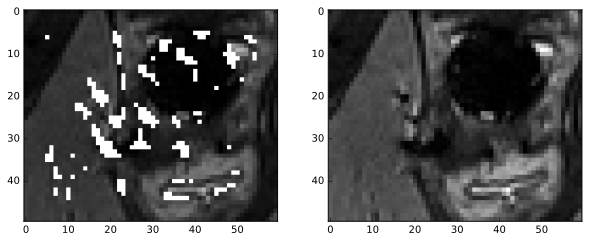

In [12]:
%matplotlib inline
%pylab inline
# We display one axial slice
Z = 13
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax1.imshow((np.clip(mask[:,:,Z]*255+im[:,:,Z]/2,a_min=0,a_max=200)).transpose(),  cmap='gray', interpolation='nearest')
ax2 = fig.add_subplot(122)
ax2.imshow(im[:,:,Z].transpose(), cmap='gray', interpolation='nearest')